In [0]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [0]:
from google.colab import files
files.upload()

In [0]:
# Загружаем данные
# Данные содержат 2-х секундные показания (частота семплирования 52 Гц) акселерометра закрепленного на груди у человека.
# 1, 2 и 3 признаки - это составляющие вектора ускорения вдоль осей x, y, z соответсвенно.
# Датасет содержит измерения для 15 разных людей
data = np.load('Accelerometer_ext.npz')
X = data['a'][:,:,:3]
#label = data['a'][:,-1,3]

In [44]:
#Датасет отсортирован, то есть данные от разных людей не перемешаны, а идут друг за другом. 
#Можно разделить набор данных на 15 равных частей по 429 наблюдений в каждом. 
#И разметить их от 1 до 15. По этим новым данным построить модель, которая будет классифицировать не виды активности, а людей.

#задаем метки классов для 15 человек
label = np.array([])
for i in range(15):
  label = np.concatenate((label,np.repeat(i,429)))
label.shape

(6435,)

In [45]:
label

array([ 0.,  0.,  0., ..., 14., 14., 14.])

In [46]:
np.unique(label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [0]:
label.shape

(6435,)

In [0]:
# Разбиение на тестовую и обучающую выборки (random_state фиксирован для повторяемости результатов)
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=999)

In [0]:
# One-Hot Encoding
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train = enc.fit_transform(y_train.reshape(-1, 1))
y_test = enc.transform(y_test.reshape(-1, 1))

In [0]:
# Полезные константы
lenght = X_train.shape[1]
num_features = X_train.shape[2]
num_classes = len(enc.categories_[0])
nb_epochs = 60
batch_size=256

1

In [0]:
# Создаем сеть
x = layers.Input((lenght, num_features))

x1 = layers.BatchNormalization()(x)
x1 = layers.SpatialDropout1D(0.1)(x1)
conv1 = layers.Conv1D(32, 8, 2, padding='same')(x1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation('relu')(conv1)
    
conv2 = layers.Conv1D(64, 5, 2, padding='same')(conv1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Activation('relu')(conv2)
    
conv3 = layers.Conv1D(32, 3, 2, padding='same')(conv2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Activation('relu')(conv3)
    
full = layers.GlobalAveragePooling1D()(conv3)    
out = layers.Dense(num_classes, activation='softmax')(full)
    
    
model = Model(inputs=x, outputs=out)
     
optimizer = optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [116]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 104, 3)]          0         
_________________________________________________________________
batch_normalization_243 (Bat (None, 104, 3)            12        
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 104, 3)            0         
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 52, 32)            800       
_________________________________________________________________
batch_normalization_244 (Bat (None, 52, 32)            128       
_________________________________________________________________
activation_156 (Activation)  (None, 52, 32)            0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 26, 64)            103

#FCN

In [114]:

hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test))

Train on 5148 samples, validate on 1287 samples
Epoch 1/60
5148/5148 [==============================] - 4s 733us/sample - loss: 2.3778 - acc: 0.2799 - val_loss: 12.1154 - val_acc: 0.0692
Epoch 2/60
5148/5148 [==============================] - 1s 222us/sample - loss: 1.9547 - acc: 0.4312 - val_loss: 13.0094 - val_acc: 0.0692
Epoch 3/60
5148/5148 [==============================] - 1s 225us/sample - loss: 1.7703 - acc: 0.4967 - val_loss: 11.6496 - val_acc: 0.0684
Epoch 4/60
5148/5148 [==============================] - 1s 228us/sample - loss: 1.6228 - acc: 0.5697 - val_loss: 11.2067 - val_acc: 0.0692
Epoch 5/60
5148/5148 [==============================] - 1s 227us/sample - loss: 1.5209 - acc: 0.5932 - val_loss: 10.0219 - val_acc: 0.0210
Epoch 6/60
5148/5148 [==============================] - 1s 233us/sample - loss: 1.4393 - acc: 0.6233 - val_loss: 8.8813 - val_acc: 0.0218
Epoch 7/60
5148/5148 [==============================] - 1s 226us/sample - loss: 1.3412 - acc: 0.6478 - val_loss: 7.6109

In [115]:
print('FCN val_acc 60 epochs ',np.max(hist.history['val_acc']))

FCN val_acc 60 epochs  0.91763794


0.91763794


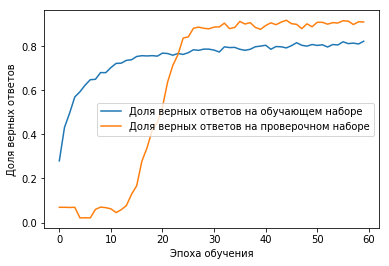

In [120]:
print(np.max(hist.history['val_acc']))
plt.plot(hist.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(hist.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#ResNet

In [0]:
filters = 32
x = layers.Input((lenght, num_features))

l1_x = layers.BatchNormalization()(x)
l1_x = layers.Conv1D(filters, 8, 1, padding='same')(l1_x)
l1_x = layers.BatchNormalization()(l1_x)
l1_x = layers.Activation('relu')(l1_x)

l1_y = layers.Conv1D(filters, 5, 1, padding='same')(l1_x)
l1_y = layers.BatchNormalization()(l1_y)
l1_y = layers.Activation('relu')(l1_y)

l1_z = layers.Conv1D(filters, 3, 1, padding='same')(l1_y)
l1_z = layers.BatchNormalization()(l1_z)

shortcut_y = layers.Conv1D(filters, 1, 1,padding='same')(x)
shortcut_y = layers.BatchNormalization()(shortcut_y)

y = layers.Add()([shortcut_y, l1_z])
y = layers.Activation('relu')(y)

x1 = y

l2_x = layers.BatchNormalization()(x1)
l2_x = layers.Conv1D(filters*2, 8, 1, padding='same')(l2_x)
l2_x = layers.BatchNormalization()(l2_x)
l2_x = layers.Activation('relu')(l2_x)

l2_y = layers.Conv1D(filters*2, 5, 1, padding='same')(l2_x)
l2_y = layers.BatchNormalization()(l2_y)
l2_y = layers.Activation('relu')(l2_y)

l2_z = layers.Conv1D(filters*2, 3, 1, padding='same')(l2_y)
l2_z = layers.BatchNormalization()(l2_z)

shortcut_y = layers.Conv1D(filters*2, 1, 1,padding='same')(x1)
shortcut_y = layers.BatchNormalization()(shortcut_y)

y = layers.Add()([shortcut_y, l2_z])
y = layers.Activation('relu')(y)

x1 = y

l3_x = layers.BatchNormalization()(x1)
l3_x = layers.Conv1D(filters*2, 8, 1, padding='same')(l3_x)
l3_x = layers.BatchNormalization()(l3_x)
l3_x = layers.Activation('relu')(l3_x)

l3_y = layers.Conv1D(filters*2, 5, 1, padding='same')(l3_x)
l3_y = layers.BatchNormalization()(l3_y)
l3_y = layers.Activation('relu')(l3_y)

l3_z = layers.Conv1D(filters*2, 3, 1, padding='same')(l3_y)
l3_z = layers.BatchNormalization()(l3_z)

shortcut_y = layers.Conv1D(filters*2, 1, 1,padding='same')(x1)
shortcut_y = layers.BatchNormalization()(shortcut_y)

y = layers.Add()([shortcut_y, l3_z])
y = layers.Activation('relu')(y)

full = layers.GlobalAveragePooling1D()(y)    
out = layers.Dense(num_classes, activation='softmax')(full)
    
    
model = Model(inputs=x, outputs=out)
     
optimizer = optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [118]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 104, 3)]     0                                            
__________________________________________________________________________________________________
batch_normalization_247 (BatchN (None, 104, 3)       12          input_39[0][0]                   
__________________________________________________________________________________________________
conv1d_209 (Conv1D)             (None, 104, 32)      800         batch_normalization_247[0][0]    
__________________________________________________________________________________________________
batch_normalization_248 (BatchN (None, 104, 32)      128         conv1d_209[0][0]                 
___________________________________________________________________________________________

In [121]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=60, verbose=1, validation_data=(X_test, y_test))

Train on 5148 samples, validate on 1287 samples
Epoch 1/60
5148/5148 [==============================] - 24s 5ms/sample - loss: 1.5154 - acc: 0.5796 - val_loss: 50.7779 - val_acc: 0.0692
Epoch 2/60
5148/5148 [==============================] - 19s 4ms/sample - loss: 0.7049 - acc: 0.8285 - val_loss: 49.7899 - val_acc: 0.0692
Epoch 3/60
5148/5148 [==============================] - 19s 4ms/sample - loss: 0.5078 - acc: 0.8801 - val_loss: 40.8578 - val_acc: 0.0692
Epoch 4/60
5148/5148 [==============================] - 19s 4ms/sample - loss: 0.4208 - acc: 0.8969 - val_loss: 32.6909 - val_acc: 0.0692
Epoch 5/60
5148/5148 [==============================] - 19s 4ms/sample - loss: 0.3777 - acc: 0.8963 - val_loss: 22.3675 - val_acc: 0.0692
Epoch 6/60
5148/5148 [==============================] - 19s 4ms/sample - loss: 0.3479 - acc: 0.9007 - val_loss: 16.9904 - val_acc: 0.0692
Epoch 7/60
5148/5148 [==============================] - 19s 4ms/sample - loss: 0.2897 - acc: 0.9149 - val_loss: 12.5091 - va

In [122]:
print('ResNet val_acc 60 epochs ',np.max(hist.history['val_acc']))

ResNet val_acc 60 epochs  0.96348095


0.96348095


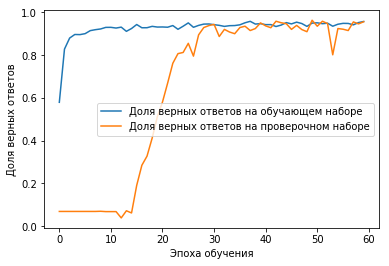

In [123]:
print(np.max(hist.history['val_acc']))
plt.plot(hist.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(hist.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Вывод

[colab](https://colab.research.google.com/drive/1tD-6WAmkn43-5p5yuuHZWcinX4P2uXwE)

Задача классификации людей на основе данных об активности. Базовая модель выдала точность на валидации около 92%, модель ResNet 96%

# Домашнее задание


**Задание Light**

Оптимизировать предложенную в шаблоне архитектуру сети изменяя:
1) Количество фильтров в сверточных слоях
2) Добавляя дропаут после сверточных слоев и подбирая его процент
3) Активации нейронов
4) Оптимизатор и его параметры
5) Stride в свертках
Опционально: Реализовать MLP или ResNet архитектуру из лекции для решения этой задачи.

**Задание Pro**
На выбор:
- Преобразовать одномерный ряд в изображение одним из методов, описанном в лекции и решить задачу классификации при помощи двумерной светрочной сети (LeNet);
- Датасет отсортирован, то есть данные от разных людей не перемешаны, а идут друг за другом.
Можно разделить набор данных на 15 равных частей по 429 наблюдений в каждом. И разметить их от 1 до 15. По этим новым данным построить модель, которая будет классифицировать не виды активности, а людей.
- Создать модель на произвольных данных. Данные можно взять с Kaggle (https://www.kaggle.com/datasets?sortBy=hottest&group=public&page=1&pageSize=20&size=all&filetype=all&license=all&tagids=6618) (фильтровать по тэгу Time Series) или в репозитории UCI (https://archive.ics.uci.edu/ml/datasets.php) (в меню слева выбрать Time Series)